# FWI Wildfire Workflow - Risk

## Load libraries
In this notebook we will use the following Python libraries:

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import cdsapi
import os
import xarray as xr
import json
import urllib
import pyproj
import cartopy.crs as ccrs
import zipfile
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re
from matplotlib.colors import TwoSlopeNorm
from rasterio.enums import Resampling
import glob
from paretoset import paretoset
import mplleaflet

:::{admonition}
:class: hint dropdown 
- [numpy](https://numpy.org/doc/stable/index.html) - To make calculations and handle data in the form of arrays.
- [pandas](https://pandas.pydata.org/docs/index.html) - To store data in the form of DataFrames.
- [geopandas](https://geopandas.org/en/stable/index.html) - To read georeferenced files as DataFrames.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - To extract files from zipped folders.
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [urllib](https://docs.python.org/3/library/urllib.html) - To download data from various repositories.
- [cdsapi](https://pypi.org/project/cdsapi/) - To download data from the Copernicus Climate Data Storage. 
- [json](https://docs.python.org/3/library/json.html) - To read GeoJson files.
- [xarray](https://docs.xarray.dev/en/stable/) - To access data in netCDF4 format.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [pyproj](https://pyproj4.github.io/pyproj/stable/) - To reproject data between different coordinate systems.
- [matplotlib](https://matplotlib.org/) and [Basemap](https://matplotlib.org/basemap/stable/)  - For plotting.


## Create the directory structure
First, we need to set up the directory structure to make the workflow run.
The next cell will create the directory called 'FWI_workflow' in the same directory where this notebook is saved. A directory for data and one for results will also be created inside the main workflow directory to store the downloaded data and the final plots. 

In [3]:
workflow_dir = 'FWI_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)

## Define the studied area

The cells below allow to download the boundaries of any NUTS2 or NUTS3 region in the EU as a GeoJson file given the region code (in this case FI19 for Western Finland). You can look up the NUTS code for all EU regions [here](https://ec.europa.eu/eurostat/documents/3859598/15193590/KS-GQ-22-010-EN-N.pdf) by simply searching the document for the region name. 

The coordinates of the selected regions are extracted and saved in an array. Finally, the geometry of the GeoJson file is saved as a shapefile to be used in the plotting phase.

In [4]:
region = ['ITG1'] #Replace the code in [''] with that of your region 

In [5]:
#auxiliary function to load region GeoJson file.
def load_nuts_json(json_path):
    # dependencies: json, urllib, geopandas, 
    while True:
        uh = urllib.request.urlopen(json_path)
        data = uh.read()
        break  
    gdf = gpd.GeoDataFrame.from_features(json.loads(data)["features"])
    gdf['Location'] = gdf['CNTR_CODE'] 
    gdf = gdf.set_index('Location')
    #gdf.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
    return gdf

# load nuts2 spatial data
json_nuts_path = 'https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326.geojson'
nuts = load_nuts_json(json_nuts_path)
nuts = nuts.loc[nuts['NUTS_ID'].isin(region)]

#extract coordinates
df=gpd.GeoSeries.get_coordinates(nuts)
coords_user=df.to_numpy()

#save geometry as shapefile
nuts_name=re.sub(r'[^a-zA-Z0-9]','',str(nuts.iloc[0,4]))
nuts_shape=nuts.geometry.explode(index_parts=True).to_file(f'{data_dir}/{nuts_name}.shp')

The code below creates the study area bounding box using the coordinates of the region GeoJson file. The coordinates are then reprojected from the source projection to the climate data projection.

In some cases, it might be needed to expand the selected area through the 'scale' parameter to avoid the corners of the region being left out from the data extraction. The units of the 'scale' parameter are degrees, so setting scale=1 will increase the extraction area by approximately 100 km. A scale of 0-0.5 should be sufficient to fully cover most regions.  

:::{warning} The larger the scale parameter, the larger the extracted area, the longer the workflow will run for. Thus, the user is invited to have a first run of the workflow with scale=0.5, then increase it if not satisfied with the data coverage of the final map.

In [6]:
# set the scale parameter
scale=0.5

#defining region bounding box
bbox=[np.min(coords_user[:,0])-scale,np.min(coords_user[:,1])-scale,np.max(coords_user[:,0])+scale,np.max(coords_user[:,1])+scale]

#setting up the projection transformation tool
crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EURO-CORDEX projection.
RLON_MIN, RLAT_MIN = transformer.transform(bbox[1], bbox[0])
RLON_MAX, RLAT_MAX = transformer.transform(bbox[3], bbox[2])

## Defining Fire Danger
In line with EFFIS methodology, fire danger is expressed as the combination of fuel availability and climatic conditions: the former is essential for wildfire development and determines the resulting fire regime, the latter regulates the rate of fire spread by controlling the fuel moisture. 

### 1. Fire Weather Index
The climatic suitability for the development of wildfire is represented here by the seasonal Fire Weather Index, combining information on weather and fuel moisture conditions. The first step in the Risk Assessment entails defining a FWI threshold for fire danger that is relevant for the region. The threshold is user defined and should be based on relevant experts and stakeholders knowledge of the regional setting. 

The user can consult the table below for guidance on selecting the most appropriate FWI threshold. **N.B.** The categorization applied to the FWI values in the table is representative of [pan-European](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-danger-forecast#:~:text=The%20Fire%20Weather%20Index%20is,Middle%20East%20and%20North%20Africa.https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-danger-forecast#:~:text=The%20Fire%20Weather%20Index%20is,Middle%20East%20and%20North%20Africa.) conditions and should only be interpreted as a general guideline. High latitude regions are unlikely to experience FWI values above 30, but this does not mean that they are not at risk of wildfire. 

| FWI value | Fire Danger Class |
| --- | --- |
| < 11.2 | Low |
| 11.2 - 21.3 | Moderate |
| 21.3 - 38.0 | High |
| 38.0 - 50.0 | Very High |
| 50.0 - 70.0 | Extreme |
| > 70 | Very Extreme |

#### Import the FWI datasets

The seasonal Fire Weather Index data is sourced from the [Copenicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=form). The projections are readily accessible to the public through the Climate Data Store (CDS) portal. The EURO-CORDEX data can be downloaded through the CDS API as shown in the [Hazard Workflow](FWI_Hazard_Assessment.ipynb). 

In the cell below, specify the RCP scenario you are interested in.

In [7]:
rcp='rcp26'

In the cell below the FWI datasets are concatenated (if more than one), then cut for the studied region. 

In [8]:
# Auxiliary function to slice each dataset to a particular region with rotated coordinates.
def cut_to_region(ds):
    ds = ds.sel(rlat = slice(RLAT_MIN, RLAT_MAX), rlon = slice(RLON_MIN, RLON_MAX))
    return ds

In [9]:
# Import the FWI file, concatenate years and cut for the chosen region
ds_FWI=xr.open_mfdataset(f'{data_dir}/mean-model_{rcp}_fwi-mean-jjas*.nc', combine='nested',
                         concat_dim='time',
                         decode_coords='all',
                         preprocess=cut_to_region)

# Extract the FWI variable from the imported dataset
FWI=ds_FWI['fwi-mean-jjas']

In [229]:
#Import the standard FWI threshold calculated in the Hazard Workflow
hist_thresh=xr.open_mfdataset(f'{results_dir}/{nuts_name}'+'_thresh_hist.nc')

#Define the FWI threshold, use a numeric value or the hist_thresh imported before.
user_thresh=20

#Filter the FWI data using the threshold
mask=FWI > user_thresh
clim_danger=FWI.where(mask.compute(),drop=True)

Since FWI is a climatic index, it does not take into account the fact that not all land covers have burnable material (i.e., lakes, bare areas etc.). The cell below filters the FWI data removing non-flammable areas (as defined by EFFIS) extracted from the ESA-CCI Land Cover dataset. First, a function is defined to extract te ESA land cover data.

In [227]:
def cut_to_region_ESA(ds):
    ds = ds.sel(lat = slice(bbox[3],bbox[1]),lon = slice(bbox[0], bbox[2]))
    return ds

In [242]:
#create a mask for the non-flammable land covers
esa=xr.open_mfdataset(f'{data_dir}/C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc',preprocess=cut_to_region_ESA)
esa_class=esa['lccs_class']
coordinates_dict = {
    'lon': clim_danger['lon'],
    'lat': clim_danger['lat']}
esa_int=esa_class.interp(coords=coordinates_dict) #interpolate ESA dataset to FWI resolution
esa_bare=esa_int < 199 #create mask

#Apply the mask to the raw FWI data
clim_esa=clim_danger.mean(dim='time')*esa_bare.squeeze() 
clim_esa=clim_esa.where(danger_esa>0) #filter out invalid data

Finally, the filtered FWI dataset is stored in a common risk dataset where all the variables making up wildfire risk will be compiled.

In [243]:
# Create dataset where to store all the danger and vulnerability variables
risk=clim_esa.to_dataset(name='clim_danger')

### 2. Burnable Area

In line with EFFIS methodology, fuel availability is estimated here using the percentage of burnable vegetation as a proxy. The higher the fraction of burnable vegetation, the more fuel will be available for fire development and spreading. The burnable area dataset is produced by EFFIS and covers the whole european domain. The extracted burnable area data will be reprojected and interpolated to match the coordinate system and resolution of the FWI dataset. 

In [232]:
# Setting up the projection transformation tool
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=10,central_latitude=52,
                                    false_easting=4321000,false_northing=3210000)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EFFIS projection.
XLON_MIN, YLAT_MIN = transformer.transform(bbox[1], bbox[0])
XLON_MAX, YLAT_MAX = transformer.transform(bbox[3], bbox[2])

def cut_to_region_EFFIS(ds):
    ds = ds.sel(y = slice(YLAT_MAX, YLAT_MIN), x = slice(XLON_MIN, XLON_MAX))
    return ds

In [234]:
# Create a mask to match the dataset extent with the FWI
mask=danger_esa>0

# Define function to extract data from the EFFIS datasets
def extract_EFFIS(ds_file):
    ds=ds_file['band_data'].mean(dim='band')
    ds_wgs84=ds.rio.reproject("EPSG:4326",resampling=Resampling.average,nodata=np.nan) #reproject to WGS84
    coordinates_dict = {
        'x': danger['lon'],
        'y': danger['lat']}
    ds_int=ds_wgs84.interp(coords=coordinates_dict) #Interpolate to danger data resolution
    ds_final=ds_int*mask #Apply danger mask
    ds_final=xr.where(ds_final>0,ds_final,np.nan) #Remove invalid data
    return ds_final

In [235]:
#Import dataset
burn_file=xr.open_mfdataset(f'{data_dir}/var-PBAP_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [236]:
#Apply the extraction function
burn_final=extract_EFFIS(burn_file)
burn_final=burn_final*100 #convert to percentage

#Assign the result to the risk dataset
risk=risk.assign(burn_area=burn_final)

### Combining danger indicators
Once we extracted the climatic and fuel danger components, we can combine them to produce a wildfire danger index. The index is produced normalising the climate and fuel datasets with the min-max method, then taking their average assigning equal weights. 

In [264]:
#Normalise the components
clim_norm=(risk['clim_danger']-risk['clim_danger'].min())/(risk['clim_danger'].max()-risk['clim_danger'].min())
burn_norm=(risk['burn_area']-risk['burn_area'].min())/(risk['burn_area'].max()-risk['burn_area'].min())
#Take the average
danger_index=(clim_norm+burn_norm)/2

#Assign the danger index to the risk dataset
risk=risk.assign(dg_index=danger_index)

### Plot fire danger

The cells below allow you to plot the fire danger index along with the climatic and fuel components. 

:::{tip} Use the 'zoom' paramerter to set how much you would like the final plot to be zoomed-out from the region boundaries (0=no zoom out,1=100 km). Here a zoom of 0.5 degrees (50 km) is used.

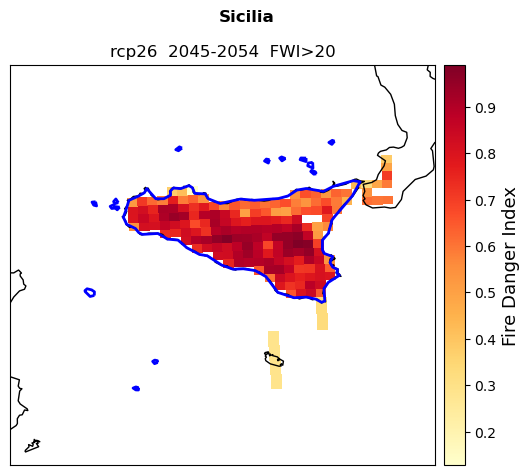

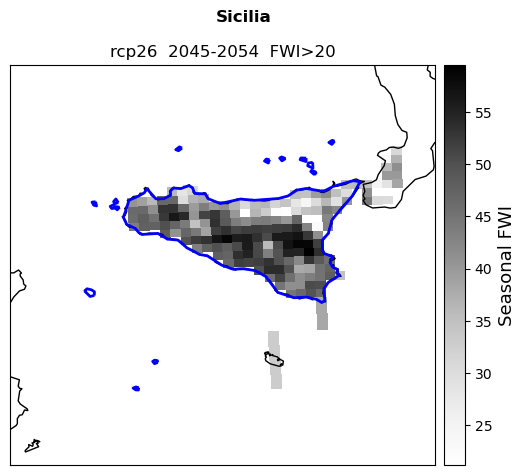

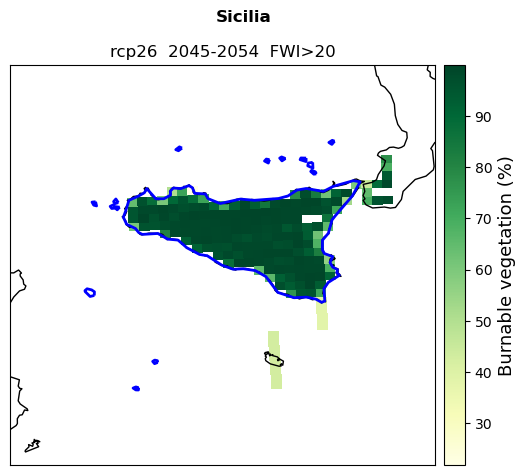

In [245]:
variables=[danger_index,clim_esa,burn_final]
labels=['Fire Danger Index', 'Seasonal FWI', 'Burnable vegetation (%)']
colors=['YlOrRd','Greys','YlGn']
name=['DangerInd','FWI','BurnVeg']

ystart=ds_FWI['time.year'][0].to_numpy() #identify the projection start year
yend=ds_FWI['time.year'][-1].to_numpy() #identify the projection end year
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=clim_danger['lon'].to_numpy()
lat_plot=clim_danger['lat'].to_numpy()

#plot 
for a,b in zip(variables,np.arange(len(variables))):
    map_FWI =Basemap(
                   resolution='i',
                   llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
                   llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
                   lon_0=bbox[1],lat_0=bbox[0])

    map_FWI.drawcoastlines()
    map_FWI.drawcountries()
    #map_FWI.contourf(lon_plot,lat_plot,danger_esa,cmap='Reds',zorder=1) 
    map_FWI.pcolormesh(lon_plot,lat_plot,a,cmap=colors[b],zorder=1) 
    map_FWI.colorbar().set_label(labels[b],fontsize=13)
    map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
    plt.suptitle(str(nuts.iloc[0,4]),fontweight='bold') #title
    plt.title(rcp+' '+' '+str(ystart)+'-'+str(yend)+'  FWI>'+str(user_thresh))
    plt.tight_layout()
    plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+name[b]+'.png') #save plots in results directory
    plt.show()

## Vulnerability

The cells below will extract vulnerability data from a series of datasets sourced from the European Forest Fire Information Service [(EFFIS)](https://forest-fire.emergency.copernicus.eu/apps/fire.risk.viewer/). The extraction and reprojection procedure is the same as for the burnable vegetation. The processed vulnerability components will also be compiled to the risk dataset.

The chosen vulnerability indicators are:
- **Population** living in the **Wildland Urban Interface**, representing the share of total population living in the periurban areas bounding forested or vegetated areas
- **Protected Areas** distribution, representing the share of each pixel of the map covered by a protected natural area
- **Ecosystem Irreplaceability Index**, representing the uniqueness and inherent value of the ecosystems present in each pixel
- **Population Density**
- **Ecosystem Restoration Cost** Index, representing the relative restoration cost of land in case of loss by wildfire

The choice of vulnerability indicators follows the methodology of the latest EFFIS [Pan-European Wildfire Risk Assessment](https://publications.jrc.ec.europa.eu/repository/handle/JRC130136) (Jacome Felix Oom et al., 2022)

#### 1. Population at the Wildland Urban Interface

In [247]:
wui_file=xr.open_mfdataset(f'{data_dir}/var-WUI-prop_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [271]:
#Apply the extraction function
wui_final=extract_EFFIS(wui_file)
wui_final=wui_final*100 #convert to percentage

#Assign the result to the risk dataset
risk=risk.assign(wu_interf=wui_final)

#### 2. Protected areas fraction

In [249]:
prot_area_file=xr.open_mfdataset(f'{data_dir}/var-PAF_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [250]:
#Apply the extraction function
prot_area_final=extract_EFFIS(prot_area_file)
prot_area_final=prot_area_final*100  #convert to percentage

#Assign to the risk dataset
risk=risk.assign(prot_area=prot_area_final)

#### 3. Ecosystems Irreplaceability

In [251]:
irrep_file=xr.open_mfdataset(f'{data_dir}/var-Irr_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [252]:
#Apply the extraction function
irrep_final=extract_EFFIS(irrep_file)

#Assign to the risk dataset
risk=risk.assign(ecol_irrep=irrep_final)

#### 4. Population density

In [253]:
pop_file=xr.open_mfdataset(f'{data_dir}/var-pop_unit-people-per-km2.tiff',
                           preprocess=cut_to_region_EFFIS)

In [254]:
#Apply the extraction function
pop_final=extract_EFFIS(pop_file)

#Assign to the risk dataset
risk=risk.assign(pop_dens=pop_final)

#### 5. Restoration cost

In [255]:
cost_file=xr.open_mfdataset(f'{data_dir}/var-vuln-econ_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [256]:
#Apply the extraction function
cost_final=extract_EFFIS(cost_file)

#Assign to the risk dataset
risk=risk.assign(restor_cost=cost_final)

### Plotting

Plot all the extracted vulnerability variables and save them in the results directory.

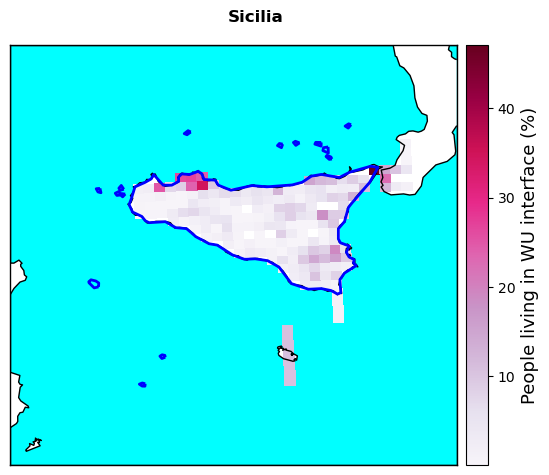

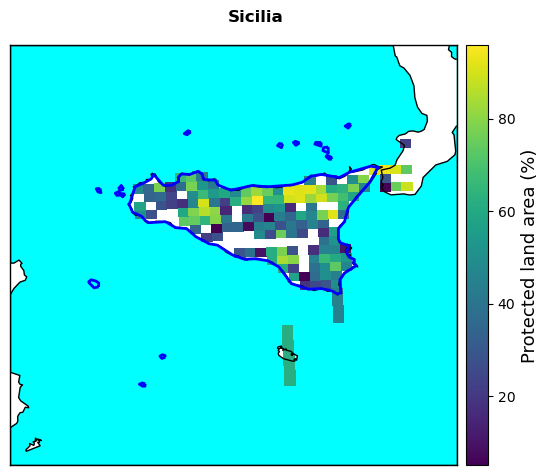

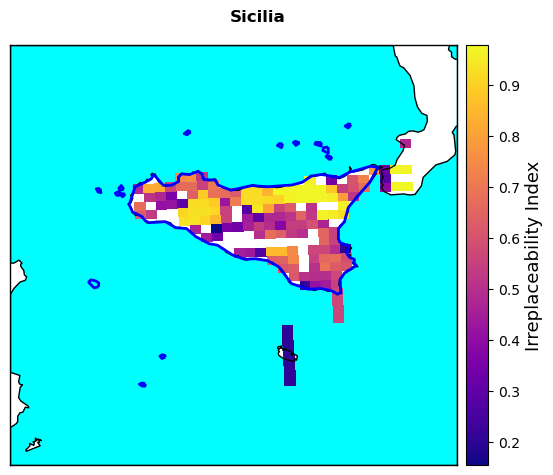

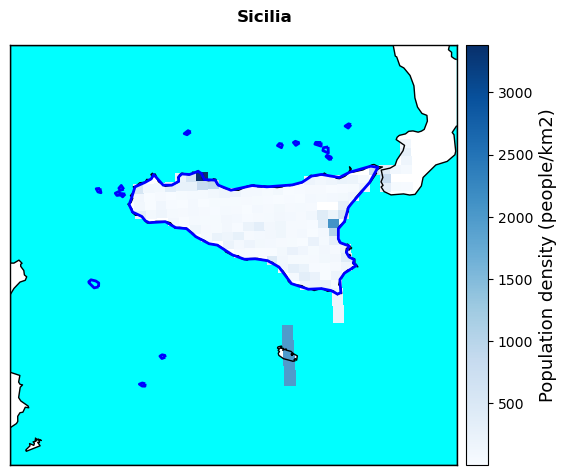

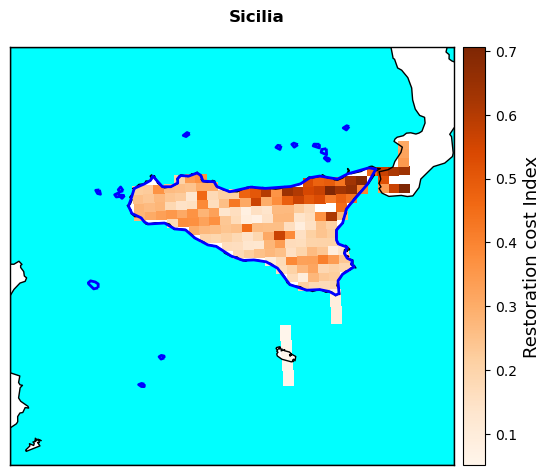

In [257]:
variables=[wui_final,prot_area_final,irrep_final,pop_final,cost_final]
colors=['PuRd','viridis','plasma','Blues','Oranges']
labels=['People living in WU interface (%)','Protected land area (%)',
       'Irreplaceability Index','Population density (people/km2)','Restoration cost Index']
outp_name=['Wui','ProtArea','Irrep','PopDens','RestCost']

zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger['lon'].to_numpy()
lat_plot=danger['lat'].to_numpy()

for i,a in zip(variables,np.arange(len(variables))):
    map_FWI =Basemap(
                   resolution='i',
                   llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
                   llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
                   lon_0=bbox[1],lat_0=bbox[0])

    map_FWI.drawcoastlines()
    map_FWI.drawmapboundary(fill_color='aqua') 
    map_FWI.fillcontinents(color='white',lake_color='aqua')
    map_FWI.drawcountries()
    map_FWI.pcolormesh(lon_plot,lat_plot,i,cmap=colors[a],zorder=1)
    map_FWI.colorbar().set_label(labels[a] ,fontsize=13)
    map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
    plt.suptitle(str(nuts.iloc[0,4]),fontweight='bold') #title
    plt.tight_layout()
    plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+outp_name[a]+'.png') #save plots in results directory
    plt.show()

In [265]:
#Display the final risk Dataarray
risk

<xarray.Dataset> Size: 52kB
Dimensions:       (rlon: 27, rlat: 20)
Coordinates:
  * rlon          (rlon) float64 216B -4.395 -4.285 -4.175 ... -1.645 -1.535
  * rlat          (rlat) float64 160B -14.79 -14.03 -13.91 ... -12.15 -12.04
    rotated_pole  |S1 1B b''
    lon           (rlat, rlon) float64 4kB 12.76 12.89 13.02 ... 15.94 16.08
    lat           (rlat, rlon) float64 4kB 35.8 35.81 35.81 ... 38.68 38.69
    time          datetime64[ns] 8B 2022-01-01
    spatial_ref   int32 4B 0
    x             (rlat, rlon) float64 4kB 12.76 12.89 13.02 ... 15.94 16.08
    y             (rlat, rlon) float64 4kB 35.8 35.81 35.81 ... 38.68 38.69
Data variables:
    clim_danger   (rlat, rlon) float64 4kB dask.array<chunksize=(20, 27), meta=np.ndarray>
    burn_area     (rlat, rlon) float64 4kB dask.array<chunksize=(20, 27), meta=np.ndarray>
    prot_area     (rlat, rlon) float64 4kB dask.array<chunksize=(20, 27), meta=np.ndarray>
    ecol_irrep    (rlat, rlon) float64 4kB dask.array<chunksize=(20, 27), meta=np.ndarray>
    pop_dens      (rlat, rlon) float64 4kB dask.array<chunksize=(20, 27), meta=np.ndarray>
    restor_cost   (rlat, rlon) float64 4kB dask.array<chunksize=(20, 27), meta=np.ndarray>
    wui_interf    (rlat, rlon) float64 4kB dask.array<chunksize=(20, 27), meta=np.ndarray>
    dg_index      (rlat, rlon) float64 4kB dask.array<chunksize=(20, 27), meta=np.ndarray>

### Pareto analysis of risk

After extracting the vulnerability indicators, these need to be combined among them and with the danger indicators to assess which areas of the region have the highest (or lowest) overall risk. To produce a uniform ranking of risk considering all the different indicators, a dedicated module is used to find the "Pareto front" of risk (see the [Risk Methodology]() document for more info). In summary, the Pareto front represents the group of pixels having the highest risk profile assuming that all factors considered in the analysis equally contribute to wildfire risk. 

:::{important} Changing the factors considered in the Pareto analysis, the result changes. Thus, the users can decide to include or exclude any vulnerability parameters in the analysis if they want to focus on a specific risk. For instance, if they wanted to focus on the risk to natural habitats they could consider only the fraction of protected area and the irreplaceability index as the vulnerability terms. In this way, the result will be the group of pixels having the highest "environmental risk". **N.B.** You should **always keep the danger** component in the Pareto analysis, as this represents the baseline for which risk itself develops.

For the Pareto analysis we are using the [paretoset](https://pypi.org/project/paretoset/) module, which needs data in [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) format to operate. The module does not handle missing values, so we need to replace them with 0.

In [272]:
#Convert the risk DataArray to a pandas DataFrame, fill missing values with 0.
risk_df=risk.to_dataframe().fillna(0)

In the cell below, specify which variables you would like to include in the analysis. Here all the vulnerability variables are selected to assess the overall risk of the region. The names of the variables are those assigned to the risk datset.

In [273]:
variables_list=['dg_index','wu_interf','prot_area','ecol_irrep','restor_cost']

The cell below performs the Pareto analysis to identify the pixels with the highest and lowest risk. For the highest risk, the module is set to look for the "max" of each indicator across the region since all indicators are directly correlated with risk. The opposite applies when the lowest risk is calculated. 

If you would like to add a parameter that is inversely correlated with wildfire risk, such as the distribution of fire fighters, this parameter would need to be ranked as "min" for the highest risk calculation and as "max" for the lowest risk.

In [275]:
#Pixels with highest risk
paret_max=paretoset(risk_df[variables_list],sense=[max,max,max,max,max]) #find index of highest vuln pixels
max_pareto=risk_df[paret_max].to_xarray() #apply index to dataframe and convert back to xarray
max_pareto_sorted=max_pareto.sortby('rlon') #sort pixels (needed for plotting)
rmax=max_pareto_sorted['dg_index'] #select any of the variables (needed for plotting)

#Pixels with lowest risk
paret_min=paretoset(risk_df[variables_list],sense=[min,min,min,min,min]) #find index of lowest vuln pixels
min_pareto=risk_df[paret_min].to_xarray() #apply index to dataframe and convert back to xarray
min_pareto_sorted=min_pareto.sortby('rlon') #sort pixels (needed for plotting)
rmin=min_pareto_sorted['dg_index'] #select any of the variables (needed for plotting)

### Plotting
The cell below plots the results of the risk analysis combining them with the danger dataset. The resulting plot gives an indication of the areas across the region with the highest wildfire risk and how this compares with the climatic danger represented by the FWI.

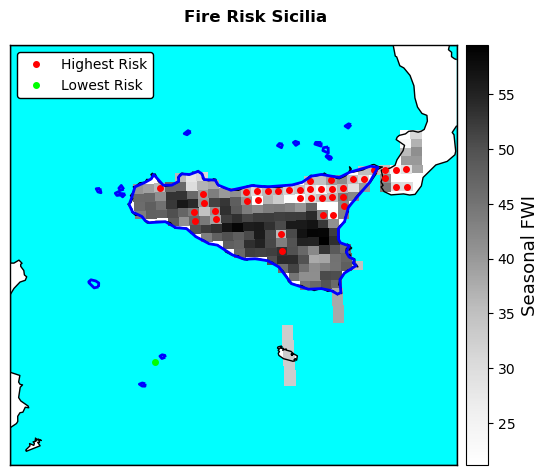

In [277]:
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger_esa['lon'].to_numpy()
lat_plot=danger_esa['lat'].to_numpy()

lon_max=max_pareto_sorted['lon'].squeeze()
lat_max=max_pareto_sorted['lat'].squeeze()

lon_min=min_pareto_sorted['lon'].squeeze()
lat_min=min_pareto_sorted['lat'].squeeze()


#set up the map and background colors
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawmapboundary(fill_color='aqua') #make sea blue 
map_FWI.fillcontinents(color='white',lake_color='aqua') #make land white, lakes blue
map_FWI.drawcountries()

#plot the danger dataset as a grey raster, the highest vulnerability points in red, the lowest in green.
map_FWI.pcolormesh(lon_plot,lat_plot,danger_esa,cmap='Greys') 
map_FWI.plot(lon_max,lat_max,rmax,marker='.',markersize=8,linestyle='None',color='r',label='Highest Risk') 
map_FWI.plot(lon_min,lat_min,rmin,marker='.',markersize=8,linestyle='None',color='lime',label='Lowest Risk') 
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile

#set the colorbar, title and legend
map_FWI.colorbar().set_label('Seasonal FWI',fontsize=13)
plt.suptitle('Fire Risk '+str(nuts.iloc[0,4]),fontweight='bold') #title
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='best',edgecolor ='k',framealpha=1)
plt.tight_layout()

#save plots in results directory
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_FireRisk.png') #save plots in results directory
plt.show()

In [278]:
#Plot results on geographical map
plt.plot(lon_max.fillna(np.nanmean(lon_max)),lat_max.fillna(np.nanmean(lat_max)),'.',color='r',markersize=11) 
plt.plot(lon_min.fillna(np.nanmean(lon_min)),lat_min.fillna(np.nanmean(lat_min)),'.',color='lime',markersize=11) 
mplleaflet.display()

C:\Users\rivoc\.conda\envs\paper_grano\Lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Contributors
Euro-Mediterranean Centre on Climate Change (CMCC), Italy

Author of the workflow: Andrea Rivosecchi

### References
Jacome Felix Oom, D., De Rigo, D., Pfeiffer, H., Branco, A., Ferrari, D., Grecchi, R., Artes Vivancos, T., Durrant, T., Boca, R., Maianti, P., Libertà, G. and San-Miguel-Ayanz, J. (2022). Pan-European wildfire risk assessment, EUR 31160 EN, Publications Office of the European Union, Luxembourg, ISBN 978-92-76-55138-6, doi:10.2760/437309, JRC130136.

## OLDDDD

In [ ]:
###NEW

In [221]:
paret2=paret.reshape((len(risk['pop_dens'][:,0]),len(risk['pop_dens'][0,:])))
paret3=np.where(paret2==True)

In [222]:
rx=risk['pop_dens'][paret3].sortby('rlon')

In [231]:
rm

<xarray.DataArray 'danger' (rlon: 17, rlat: 16)> Size: 2kB
array([[20.17798519,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan, 25.69242411,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan, 29.51260166, 20.22862864,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan, 32.47717948,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan, 23.42200102,
        32.27135444, 31.7091537 ,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
...
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, 31.62267647,         nan,
                nan, 24.5477915 ,         nan,         nan,         nan,
                nan],
       [36.72051334,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, 22.43878773,         nan,
                nan, 29.05444245,         nan,         nan,         nan,
                nan],
       [35.79166784,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
        32.4942071 ],
       [33.21205935,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [31.79684052,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan]])
Coordinates:
  * rlon     (rlon) float64 136B -13.41 -12.43 -12.32 ... -11.0 -10.89 -10.77
  * rlat     (rlat) float64 128B -6.435 -6.875 -6.985 ... -7.425 -7.205 -6.655

In [266]:
paret_max=paretoset(risk_df[['wu_interf','pop_dens','restor_cost']],
                sense=[max,max,max])
paret_min=paretoset(risk_df[['wu_interf','pop_dens','restor_cost']],
                sense=[min,min,min])
max_pareto=risk_df[paret_max].to_xarray()
min_pareto=risk_df[paret_min].to_xarray()

In [267]:
max_pareto_sorted=max_pareto.sortby('rlon')
min_pareto_sorted=min_pareto.sortby('rlon')

In [268]:
rmax=max_pareto_sorted['danger'].mean(dim='time')
rmin=min_pareto_sorted['danger'].mean(dim='time')

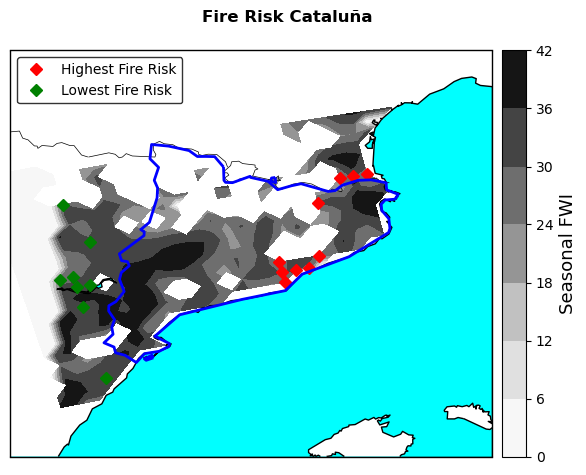

In [269]:
#Plot wildland urban interface 
import numpy.ma as ma
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger2['lon'].to_numpy()
lat_plot=danger2['lat'].to_numpy()

lon_max=max_pareto_sorted['lon'].squeeze()
lat_max=max_pareto_sorted['lat'].squeeze()

lon_min=min_pareto_sorted['lon'].squeeze()
lat_min=min_pareto_sorted['lat'].squeeze()


#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawmapboundary(fill_color='aqua') 
map_FWI.fillcontinents(color='white',lake_color='aqua')
map_FWI.drawcountries()
#map_FWI.warpimage('https://basemaps.arcgis.com/v1/arcgis/rest/services/World_Basemap/VectorTileServer/tile/{z}/{y}/{x}.pbf')
map_FWI.contourf(lon_plot,lat_plot,danger2.squeeze(),cmap='Greys') 
map_FWI.plot(lon_max,lat_max,rmax,marker='D',linestyle='None',color='r',label='Highest Fire Risk') 
map_FWI.plot(lon_min,lat_min,rmin,marker='D',linestyle='None',color='g',label='Lowest Fire Risk') 
#map_FWI.contourf(lon_par,lat_par,rm) 
map_FWI.colorbar().set_label('Seasonal FWI',fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Fire Risk '+str(nuts.iloc[0,4]),fontweight='bold') #title
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='best',edgecolor ='k')
plt.tight_layout()
#plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_SeasonalFWI.png') #save plots in results directory
plt.show()

In [271]:
#define the longitude and latitude coordinates
lon_plot=danger2['lon'].to_numpy()
lat_plot=danger2['lat'].to_numpy()

lon_par=risk_pareto_sorted['lon'].squeeze()
lat_par=risk_pareto_sorted['lat'].squeeze()

#plot soil available water capacity

#plt.hold(True)
plt.plot(lon_max.fillna(np.nanmean(lon_max)),lat_max.fillna(np.nanmean(lat_max)),'rs',markersize=11) 
plt.plot(lon_min.fillna(np.nanmean(lon_min)),lat_min.fillna(np.nanmean(lat_min)),'gs',markersize=11) 

#draw region boundaries from shapefile
#plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_SeasonalFWI.png') #save plots in results directory
mplleaflet.display()